<a href="https://colab.research.google.com/github/alekrul/RL/blob/main/MonteCarloControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
gamma = 0.9
ACTION_SPACE = ('U','L','D','R')

In [ ]:
#rewards = {(0,3): 1 , (1,3): -1}
actions = {
    (0,0): ('D','L'),
    (0,1): ('R','L'),
    (0,2): ('R','D','L'),
    (1,0): ('D','U'),
    (1,2): ('D','U','R'),
    (2,0): ('U','R'),
    (2,1): ('R','L'),
    (2,2): ('U','L','R'),
    (2,3): ('L','U')

}

In [ ]:
#policy to be evaluated
  ### fixed policy ###
policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
}

In [ ]:
class Grid: # Environment
  def __init__(self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def get_next_state(self, s, a):
    # this answers: where would I end up if I perform action 'a' in state 's'?
    i, j = s[0], s[1]

    # if this action moves you somewhere else, then it will be in this dictionary
    if a in self.actions[(i, j)]:
      if a == 'U':
        i -= 1
      elif a == 'D':
        i += 1
      elif a == 'R':
        j += 1
      elif a == 'L':
        j -= 1
    return i, j

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())

In [ ]:
def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # x means you can't go there
  # s means start position
  # number means reward at that state
  # .  .  .  1
  # .  x  . -1
  # s  .  .  .
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


In [ ]:
def play_game(grid,policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ACTION_SPACE) # first action is uniformly random

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  seen_states.add(grid.current_state())
  num_steps = 0
  while True:
    r = grid.move(a)
    num_steps += 1
    s = grid.current_state()

    if s in seen_states:
      # hack so that we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
      #   reward = -10
      # else:
      #   reward = falls off by 1 / num_steps
      reward = -10. / num_steps
      states_actions_rewards.append((s, None, reward))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + gamma*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns



In [ ]:
def max_dict(d):
  max_key = None
  max_val = float('-inf')
  for k,v in d.items():
    if v>max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [ ]:
def print_values(V, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")

In [ ]:
def print_policy(P, g):
  for i in range(g.rows):
    print("---------------------------")
    for j in range(g.cols):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")


In [ ]:
grid = standard_grid()
policy = {}

In [ ]:
Q = {}
returns = {}
states = grid.all_states()
for s in states:
  if s in grid.actions:
    Q[s] = {}
    for a in ACTION_SPACE:
      Q[s][a] = 0
      returns[(s,a)] = []
  else:
    pass

In [ ]:
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ACTION_SPACE)

0
1000


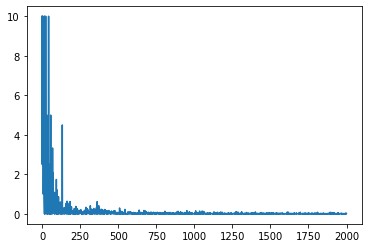

final policy
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  L  |
final values
---------------------------
-0.22|-0.02| 1.00| 0.00|
---------------------------
-0.54| 0.00|-0.31| 0.00|
---------------------------
-0.88|-1.02|-0.43|-0.97|


In [ ]:
deltas = []
for i in range(2000):
  #print(i)
  if i % 1000 == 0:
    print(i)
  biggest_change = 0
  states_actions_returns = play_game(grid, policy)
  seen_state_action_pairs = set()
  for s, a, G in states_actions_returns:
    sa = (s,a)
    if sa not in seen_state_action_pairs:
      old_q = Q[s][a]
      returns[sa].append(G)
      Q[s][a] = np.mean(returns[sa])
      biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
      seen_state_action_pairs.add(sa)
  deltas.append(biggest_change)

  for s in policy.keys():
    policy[s] = max_dict(Q[s])[0]

plt.plot(deltas)
plt.show()

print("final policy")
print_policy(policy, grid)

V = {}
for s, Qs in Q.items():
  V[s] = max_dict(Q[s])[1]
print("final values")
print_values(V, grid)

In [ ]:
policy

{(0, 0): 'R',
 (0, 1): 'R',
 (0, 2): 'R',
 (1, 0): 'U',
 (1, 2): 'U',
 (2, 0): 'U',
 (2, 1): 'L',
 (2, 2): 'U',
 (2, 3): 'L'}